In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn 
from keras.layers import Dense
from keras.models import Sequential
import os
import matplotlib.pyplot as plt
import math

df = pd.read_csv('/home/saichaitanya/Chaitanya/CSV files/1000 points per trajectory/May10rd1percent_RLV_data 1000 points.csv',header = None,names = ['h','v','s','omega','gamma','m','theta','Thrust','beta','time'])
# input = output =df.values
# X = input[:,0:7]
# y = output[:,7:9]
# Individual Data
R0 = 6378*1000;
g0=9.81
Cd = 0.5
S_ref =10.75
Isp =300;
I_z = 3346393
l_com = 9.778
t_ref = 32
h0=5000;
v0=325;
s0=850;
## The inputs and outputs which varied have values in decimals 
## rest all have been rounded off to 5-6 digits
omega0= 0.342
theta0= round(-75*math.pi/180,4)
gamma0= round(-75*math.pi/180,4) #
m0= round(26229.667,0) # our values of mass are rounded of when taking data
r0 = h0+6378000

idx = df.loc[(df['h'] == h0) & (df['v'] == v0)]
idx = np.array(idx.index.astype(int))
def trajectory_finding(idx,df,s0):
    # we have 3003 points for getting full trajectory starting from index 0-3002
    for i in range(idx.shape[0]):
        df2= df[idx[0]+3003*i:idx[0]+3003*(i+1)]
        if (df2.s.values[3002]==s0):
            break
        else:
            continue
    return np.array([df2.index[0],df2.index[3002]])

idx_i,idx_f = trajectory_finding(idx,df,s0)



2022-05-23 12:43:49.987226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-23 12:43:49.987277: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-23 12:43:49.988033: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The Number of Hidden units used is:  128
94/94 [==============================] - 0s 2ms/step - loss: 6.0173e-07 - accuracy: 0.9993


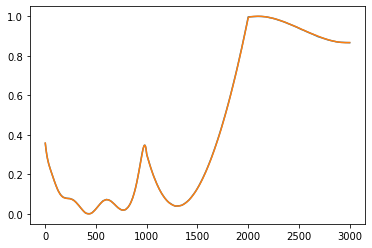

In [2]:
input = output = df.values[idx_i:idx_f]
X = input[:,0:7]
y = output[:,7:9]

from sklearn import preprocessing
X_norm = preprocessing.minmax_scale(X)
y_norm = preprocessing.minmax_scale(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.1, random_state=42)
X_val = X_train[-int(X.shape[0]*0.1):]
y_val = y_train[-int(X.shape[0]*0.1):]
X_train = X_train[:-int(X.shape[0]*0.1)]
y_train = y_train[:-int(X.shape[0]*0.1)]

## Normalizing the inputs
def norm(a,b):
    return (a - min(b))/(max(b) - min(b))
def norm_inputs(a,b):
    return (a-min(b))/(max(b)-min(b))

h = X[:,0];
v = X[:,1];
s = X[:,2];
omega = X[:,3]
gamma= X[:,4]
m = X[:,5]
theta = X[:,6]
T = y[:,0]
b = y[:,1]
r = 6378000+h

h_norm = norm_inputs(h,h)
v_norm= norm_inputs(v,v)
s_norm= norm_inputs(s,s)
omega_norm= norm_inputs(omega,omega)
gamma_norm= norm_inputs(gamma,gamma)
m_norm= norm_inputs(m,m)
theta_norm= norm_inputs(theta,theta)
r_norm = norm_inputs(r,r)
T_norm = norm_inputs(T,T)
b_norm = norm_inputs(b,b)

data_norm = np.array([r_norm,h_norm,v_norm,s_norm,omega_norm,gamma_norm,m_norm,theta_norm,T_norm,b_norm]).T
df_norm = pd.DataFrame(data_norm,columns=['r','h','v','s','omega','gamma','m','theta','Thrust','beta'])
# Trajectory for the given initial condition:
data_traj = df_norm.values[:,0:10]
ip_traj = data_traj[:,1:8]
op_traj = data_traj[:,8:10]
def AntiNorm(Norm_value,actual):
  return (max(actual)-min(actual))*Norm_value+min(actual)

def create_model2(n):
    model = Sequential()
    model.add(Dense(n,input_shape=(7,),kernel_initializer='uniform'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu')) # since tanh has more nonlinearity we add it here, it also gives -ve values so , some layers which are not necessary will lead to 0 in next layer
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(n,kernel_initializer='uniform',activation = 'relu'))
    model.add(Dense(2,kernel_initializer='uniform',activation = 'sigmoid'))
    return model

i = 7;
model = create_model2(2**i)
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.mean_squared_error
def lr_sch3(epoch,lr):
    if (epoch>0)& (epoch<60):
      if epoch%15==0: # for every 100 epochs the learning rate varies as metioned. 
        return round(lr*np.exp(-0.45),7)
      else:
        return round(lr,7)
    elif(epoch>60):
        if epoch%5==0:
            return round(lr*0.85,9)
        else:
            return round(lr,9)
    else:
        return round(lr,9)
print("The Number of Hidden units used is: ",2**i)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_sch3,verbose = 1)
bs = 1;
STEPS_PER_EPOCH = X_train.shape[0] / bs
save_period = 5
checkpoint_path = f"/home/saichaitanya/Chaitanya/GOOGLE COLAB  DOCS/one traj/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                            save_freq=int(save_period*STEPS_PER_EPOCH))
model.compile(optimizer = opt, loss = loss, metrics = 'accuracy')
iter1 = 150

model.load_weights(checkpoint_path)

model.evaluate(X_norm,y_norm)

## since we are doing simulation for only 1 trajectory we have idx_i =0 as initial point
idx_i = 0
h1 = h_norm[idx_i]
s1 = s_norm[idx_i]
v1 = v_norm[idx_i]
omega1 = omega_norm[idx_i]
m1 = m_norm[idx_i]
theta1 = theta_norm[idx_i]
gamma1 = gamma_norm[idx_i]
r1 = r_norm[idx_i] # this is < 1 since 1 is 5025.2

pred = model.predict(X_norm)
plt.plot(pred[:,0])
plt.plot(op_traj[:,0])

ip_traj2 = np.array([r_norm,v_norm,s_norm,omega_norm,gamma_norm,m_norm,theta_norm]).T

Tvec = np.squeeze(model.predict(ip_traj2))[:,0]
bvec = np.squeeze(model.predict(ip_traj2))[:,1]

TT = AntiNorm(Tvec,T)/(m0*g0)
bb = AntiNorm(bvec,b)

In [3]:
rvec = AntiNorm(r_norm,r)/(R0)
svec = AntiNorm(s_norm,s)/(s0)
vvec = AntiNorm(v_norm,v)/(v0)
gammavec = AntiNorm(gamma_norm,gamma)
mvec = AntiNorm(m_norm,m)/(m0)
thetavec = AntiNorm(theta_norm,theta)/1
omegavec = AntiNorm(omega_norm,omega)

In [4]:
# r1,s1,v1,gamma1,m1,theta1,omega1
vec = np.array([rvec,svec,vvec,gammavec,mvec,thetavec,omegavec]).T

In [5]:
pred = model.predict(X_norm)

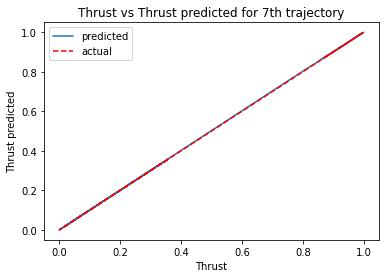

In [6]:
plt.plot(y_norm[:,0],pred[:,0])
plt.plot(y_norm[:,0],y_norm[:,0],color = 'red',linestyle='dashed')
plt.xlabel("Thrust")
plt.ylabel("Thrust predicted")
plt.legend(['predicted','actual'])
plt.title(f"Thrust vs Thrust predicted for {i}th trajectory")
plt.savefig(f"9.1.png")

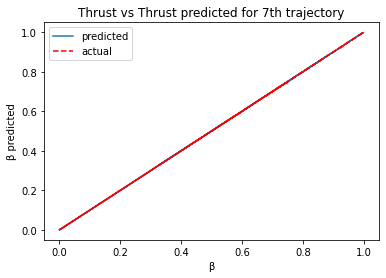

In [7]:
plt.plot(y_norm[:,1],pred[:,1])
plt.plot(y_norm[:,1],y_norm[:,1],color = 'red',linestyle='dashed')
plt.xlabel("β")
plt.ylabel("β predicted")
plt.legend(['predicted','actual'])
plt.title(f"Thrust vs Thrust predicted for {i}th trajectory")
plt.savefig(f"9.2.png")

# Starts here

In [8]:
s1 = s_norm[idx_i]
v1 = v_norm[idx_i]
omega1 = omega_norm[idx_i]
m1 = m_norm[idx_i]
theta1 = theta_norm[idx_i]
gamma1 = gamma_norm[idx_i]
r1 = r_norm[idx_i]

r1 = AntiNorm(r1,r)
s1 = AntiNorm(s1,s)
v1 = AntiNorm(v1,v)
gamma1 = AntiNorm(gamma1,gamma)
m1 = AntiNorm(m1,m)
theta1 = AntiNorm(theta1,theta)
omega1 = AntiNorm(omega1,omega)

r1 = (r1)/R0;
s1 = s1/s0;
v1 = v1/v0;
m1 = m1/m0;

y1 = np.array([r1,s1,v1,gamma1,m1,theta1,omega1])
hmatlab = [0.00715706708403029, 0.00240899798425656, 0.00010443435447363]

dy = np.zeros(7)
r2=s2=v2=gamma2=theta2=omega2=m2=[]        

i = j = 0

In [17]:
i1 = np.array([r1,s1,v1,gamma1,m1,theta1,omega1])

In [ ]:
n = 3002
for i in range(n):
    T1 = TT[i]
    if i<1001:
        h_step = hmatlab[0]
    elif i<2002:
        h_step = hmatlab[1]
    elif i<3002:
        h_step = hmatlab[2]
#     h_step = 1/n
    beta = bb[i]
    Dr = 0.5*1.225*((v1*v0)**2)*Cd*S_ref/(m0*g0);
    dy[0] = v1 * np.sin(gamma1)*(v0*t_ref/R0); 
    dy[1] = v1 * np.cos(gamma1)*(v0*t_ref/s0);    
    dy[2] = - (((T1* np.cos(beta-gamma1 + theta1) + Dr)/ m1) + (np.sin(gamma1)/(r1**2))) * (g0*t_ref/v0);
    dy[3] = - ((T1 * np.sin(beta-gamma1 + theta1)/(m1*v1)) + (np.cos(gamma1)/((r1**2)*v1))) * (g0*t_ref/v0);
    dy[4] = -T1/Isp * t_ref;
    dy[5] = omega1 * t_ref; 
    dy[6] = -T1 * np.sin(beta)*l_com*m0*g0*t_ref/I_z
    y2 = y1 + h_step * dy
    y1 = y2
    # using the values for next iterations
    r1 = y2[0]
    s1 = y2[1]
    v1 = y2[2]
    gamma1 = y2[3]
    m1 = y2[4]
    theta1= y2[5]
    omega1 = y2[6]
    #         print(r1)
    # appending the values in vector
    r2 = np.append(r2,r1)
    s2 = np.append(s2,s1)
    v2 = np.append(v2,v1)
    gamma2 = np.append(gamma2,gamma1)
    theta2 = np.append(theta2,theta1)
    m2= np.append(m2,m1)
    omega2 = np.append(omega2,omega1)
y1

In [ ]:
plt.plot(r2)


In [23]:
# global variables for appending
ω_dnn = [];
θ_dnn = [];
v_dnn = [];
γ_dnn = [];
r_dnn = [];
s_dnn = [];
h_dnn = [];
m_dnn = [];
T_dnn = [];
b_dnn = [];

In [24]:
def diff_eqn3(inputs,model): # sends norm inputs
        global ω_dnn, θ_dnn, v_dnn,γ_dnn,r_dnn, s_dnn,h_dnn ,m_dnn ,T_dnn ,b_dnn
        """ Debugg ω, γ"""
        r1 = inputs[0]
        s1 = inputs[1]
        v1 = inputs[2]
        gamma1 = inputs[3]
        m1 = inputs[4]
        theta1= inputs[5]
        omega1 = inputs[6]        
        ip = np.array([r1,v1,s1,omega1,gamma1,m1,theta1]).reshape(1,7) 
        data = model.predict(ip)
        T1,beta = np.squeeze(data)
        
        r1 = AntiNorm(r1,r)
        s1 = AntiNorm(s1,s)
        v1 = AntiNorm(v1,v)
        gamma1 = AntiNorm(gamma1,gamma)
        m1 = AntiNorm(m1,m)
        theta1 = AntiNorm(theta1,theta)
        omega1 = AntiNorm(omega1,omega)
        
        T1 = AntiNorm(T1,T)
        beta = AntiNorm(beta,b)

        r1 = (r1)/R0; # here r1 is already R0+h
        s1 = s1/s0;
        v1 = v1/v0;
        m1 = m1/m0;
        T1 = T1/(m0*g0)

        y1 = np.array([r1,s1,v1,gamma1,m1,theta1,omega1]) # anti norms

        dy = np.zeros(7)
        Dr = 0.5*1.225*((v1*v0)**2)*Cd*S_ref/(m0*g0);
        
        dy[0] = v1 * np.sin(gamma1)*(v0*t_ref/R0); 
        dy[1] = v1 * np.cos(gamma1)*(v0*t_ref/s0);    
        dy[2] = - (((T1* np.cos(beta-gamma1 + theta1) + Dr)/ m1) + (np.sin(gamma1)/(r1**2))) * (g0*t_ref/v0);
        dy[3] = - ((T1 * np.sin(beta-gamma1 + theta1)/(m1*v1)) + (np.cos(gamma1)/((r1**2)*v1))) * (g0*t_ref/v0);
        dy[4] = -T1/Isp * t_ref;
        dy[5] = omega1 * t_ref; 
        dy[6] = -T1 * np.sin(beta)*l_com*m0*g0*t_ref/I_z
        
        ω_dnn = np.append(ω_dnn,omega1)
        θ_dnn = np.append(θ_dnn,theta1)
        γ_dnn = np.append(γ_dnn,gamma1)
        r_dnn = np.append(r_dnn,r1)
        s_dnn = np.append(s_dnn,s1)
        v_dnn = np.append(v_dnn,v1)
        m_dnn = np.append(m_dnn,m1)
        T_dnn = np.append(T_dnn,T1)
        b_dnn = np.append(b_dnn,beta)
        
        
        return dy,y1,T,norm(beta,b) 

In [25]:
TT

array([1.8706455, 1.8655366, 1.8617816, ..., 2.3506484, 2.3506398,
       2.350631 ], dtype=float32)

In [26]:
def rk4_i(n,input0):
    for i in range(n):
#         T1 = TT[i]
        if i<1001:
            h_step = hmatlab[0]
        elif i<2002:
            h_step = hmatlab[1]
        elif i<3002:
            h_step = hmatlab[2]
    
    inputs= input0 #np.array([r1,s1,v1,gamma1,m1,theta1,omega1])
    op_dnn = np.append([],inputs) 
    op_an = []   
    for _ in range(n):
        k1,y1,T1,b1 = diff_eqn3(inputs,model)
        k2,_,_,_ = diff_eqn3(inputs+0.5*h_step*k1,model)
        k3,_,_,_ = diff_eqn3(inputs+0.5*h_step*k2,model)
        k4,_,_,_ = diff_eqn3(inputs+h_step*k3,model)
    
        y2 = y1+ h_step *(k1+2*(k2+k3)+k4)/6 
        
        """change y2 to normalized and append to op
           y1 = np.array([r1,s1,v1,gamma2,m1,theta2,omega2]) """
        
        # Normalizing them back to the way our neural network will be able to predict
        y2[0] = norm((y2[0])*R0,r) 
        y2[1] = norm(y2[1]*s0,s)
        y2[2] = norm(y2[2] *v0,v)
        y2[3] = norm(y2[3],gamma)
        y2[4] = norm(y2[4] *m0,m)
        y2[5] = norm(y2[5],theta)
        y2[6] = norm(y2[6],omega)
        ## 
#         print("AFTER",y2)
        inputs = y2 
        op_dnn = np.append(op_dnn,y2) # appending trajectory states obtained by ddnn
    
    return op_an,op_dnn
    

In [27]:
rk4_i(3003,i1)

/tmp/ipykernel_184090/2085586485.py:16: RuntimeWarning: invalid value encountered in add
  k2,_,_,_ = diff_eqn3(inputs+0.5*h_step*k1,model)


([], array([inf, inf, inf, ..., nan, nan, nan]))

In [ ]:
plt.plot(gamma2)

# m

In [ ]:
len(b)

In [ ]:
def traj_gen(inputs,Tvec,bvec):
    r1 = inputs[0]
    s1 = inputs[1]
    v1 = inputs[2]
    gamma1 = inputs[3]
    m1 = inputs[4]
    theta1= inputs[5]
    omega1 = inputs[6]        

    r1 = AntiNorm(r1,r)
    s1 = AntiNorm(s1,s)
    v1 = AntiNorm(v1,v)
    gamma1 = AntiNorm(gamma1,gamma)
    m1 = AntiNorm(m1,m)
    theta1 = AntiNorm(theta1,theta)
    omega1 = AntiNorm(omega1,omega)

    r1 = (r1)/R0;
    s1 = s1/s0;
    v1 = v1/v0;
    m1 = m1/m0;
    TT = AntiNorm(Tvec,T)/(m0*g0)
    bb = AntiNorm(bvec,b)
    y1 = np.array([r1,s1,v1,gamma1,m1,theta1,omega1]) # anti norms
    h_step = 1/(len(b)+1)

    dy = np.zeros(7)
    Dr = 0.5*1.225*((v1*v0)**2)*Cd*S_ref/(m0*g0);
    r2=s2=v2=gamma2=theta2=omega2=m2=[]
    
    for i in range(1):
        T1 = TT[i]
        beta = bb[i]
        Dr = 0.5*1.225*((v1*v0)**2)*Cd*S_ref/(m0*g0);
        dy[0] = v1 * np.sin(gamma1)*(v0*t_ref/R0); 
        dy[1] = v1 * np.cos(gamma1)*(v0*t_ref/s0);    
        dy[2] = - (((T1* np.cos(beta-gamma1 + theta1) + Dr)/ m1) + (np.sin(gamma1)/(r1**2))) * (g0*t_ref/v0);
        dy[3] = - ((T1 * np.sin(beta-gamma1 + theta1)/(m1*v1)) + (np.cos(gamma1)/((r1**2)*v1))) * (g0*t_ref/v0);
        dy[4] = -T1/Isp * t_ref;
        dy[5] = omega1 * t_ref; 
        dy[6] = -T1 * np.sin(beta)*l_com*m0*g0*t_ref/I_z
        
        y2 = y1 + h_step * dy
        print(y2,dy)
        # using the values for next iterations
        r1 = y2[0]
        s1 = y2[1]
        v1 = y2[2]
        gamma1 = y2[3]
        m1 = y2[4]
        theta1= y2[5]
        omega1 = y2[6]
        print(r1)
        # appending the values in vector
        r2 = np.append(r2,r1)
        s2 = np.append(s2,s1)
        v2 = np.append(v2,v1)
        gamma2 = np.append(gamma2,gamma1)
        theta2 = np.append(theta2,theta1)
        m2= np.append(m2,m1)
        omega2 = np.append(omega2,omega1)
        
        
    return r2,s2,v2,gamma2,theta2,m2,omega2



## D


In [ ]:
ip_traj3 = np.array([r_norm,s_norm,v_norm,gamma_norm,m_norm,theta_norm,omega_norm]).T
i3 = ip_traj3[0,:]

In [ ]:
# vec = np.array([rvec,svec,vvec,gammavec,mvec,thetavec,omegavec]).T
vec[0,:]

In [ ]:
traj_gen(i3,Tvec,bvec)

In [ ]:
r2